In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import skimage as ski
import pickle
import czifile

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [2]:
from fitting import fitgaussian3d, gaussian3d
from imagep import get_object_centroid, clamp, labelmask_filter_objsize, relabel_labelmask

def fit_objects_from_mask(stack, mask, fitwindow_rad_xy=10, fitwindow_rad_z=2):  
    def get_fitwindow(data, peak, xy_rad, z_rad):
        """Retrieve section of image stack corresponding to given
        window around a point and the coordinate adjustments necessary
        to convert window coordinates to coordinates in the original image"""
        
        # Set the start points for windows and "adjust" them if they get 
        # to negative numbers.
        zmin = peak[0] - z_rad
        xmin = peak[1] - xy_rad
        ymin = peak[2] - xy_rad
        # Initialize adjustments to values that are correct if no edge problems 
        # are encountered.
        z_adj = -z_rad
        x_adj = -xy_rad
        y_adj = -xy_rad
        # Update mins and adjustments if windows start at negative coordinates.
        if (zmin < 0):
            zmin = 0
            z_adj = -peak[0]
        if (xmin < 0):
            xmin = 0
            x_adj = -peak[1]
        if (ymin < 0):
            ymin = 0
            y_adj = -peak[2]

        # Get end points, constained by max coordinate in data.
        zmax = min(data.shape[0] - 1, peak[0] + z_rad)
        xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
        ymax = min(data.shape[2] - 1, peak[2] + xy_rad)

        return (data[zmin:(zmax+1), xmin:(xmax+1), ymin:(ymax+1)], z_adj, x_adj, y_adj)
    
    def get_centroids(labelmask):
        centroids = []
        for id_ in np.unique(labelmask):
            centroids.append(get_object_centroid(labelmask, id_))
        return centroids
    
    def fit_frame(substack, submask):
        labelmask = ndi.label(submask)[0]
        peaks = get_centroids(labelmask)
        
        # Fit 3D gaussian in window surrounding each local maximum.
        fitparams = np.ndarray((0,7))
        for peak in peaks:
            fitwindow, z_adj, x_adj, y_adj = get_fitwindow(substack, peak, fitwindow_rad_xy, 
                fitwindow_rad_z)
            opt = fitgaussian3d(fitwindow)
            if opt.success:
                peak_fitparams = opt.x
                # Move center coordinates to match center of gaussian fit, ensure they're within image. 
                # If they're outside the image, coordinate is assigned as the edge of the image.
                peak_fitparams[0] = int(round(clamp((peak[0] + peak_fitparams[0] + z_adj), 0, substack.shape[-3]-1)))
                peak_fitparams[1] = int(round(clamp((peak[1] + peak_fitparams[1] + x_adj), 0, substack.shape[-2]-1)))
                peak_fitparams[2] = int(round(clamp((peak[2] + peak_fitparams[2] + y_adj), 0, substack.shape[-1]-1)))
                fitparams = np.vstack((fitparams, peak_fitparams))
            # If fit fails, add dummy entry for spot.
            else:
                fitparams = np.vstack((fitparams, np.array([z_adj,x_adj,y_adj,0,np.inf,np.inf,np.inf])))
        return fitparams
    
    fit_data = []
    for t in range(0, stack.shape[0]):
        print(t)
        fit_data.append(fit_frame(stack[t], mask[t]))
    
    return fit_data

def fits_adjust_nucmovement(labelmask, fits):
    num_objects = len(np.unique(labelmask))
    num_frames = labelmask.shape[0]
    positions = np.empty((2, num_objects, num_frames))
    positions[:] = np.nan
    for f in range(0, num_frames):
        labels = np.unique(labelmask[f])
        for label in labels:
            centroid = get_object_centroid(labelmask[f], label)
            x,y = centroid[-2:]
            positions[0, label, f] = x
            positions[1, label, f] = y
    
    mean_changes = np.zeros((2, positions.shape[2]))
    for pos in range(0,2):
        for col in range(1, positions.shape[2]):
            changes = positions[pos,:,col] - positions[pos,:,0]
            mean = int(np.nanmean(changes))
            mean_changes[pos, col] = mean
    x_adjustments = mean_changes[0]
    y_adjustments = mean_changes[1]
    #return mean_changes
    
    fits_adj = []
    fits_adj.append(fits[0])
    for f in range(1, len(fits)):
        adj = fits[f].copy()            
        adj[:,1] = adj[:,1] - x_adjustments[f]
        adj[:,2] = adj[:,2] - y_adjustments[f]
        fits_adj.append(adj)
    return fits_adj, x_adjustments, y_adjustments

def revert_nucmovement_adjustments(spot_data, x_adjustments, y_adjustments):
    spot_data_r = {}
    for spot_id in spot_data.keys():
        arr = spot_data[spot_id].copy()
        for i in range(0, spot_data[spot_id].shape[0]):
            #3,4
            t = int(spot_data[spot_id][i,0])
            x_adjustment, y_adjustment = x_adjustments[t], y_adjustments[t]
            arr[i,3] = arr[i,3] + x_adjustment
            arr[i,4] = arr[i,4] + y_adjustment
        spot_data_r[spot_id] = arr
    return spot_data_r

def segment_nuclei3D_simple(substack, sigma=3, size_min=0, size_max=np.inf):
    sm = ndi.gaussian_filter(substack, sigma)
    t = ski.filters.thresholding.threshold_otsu(sm)
    mask = np.where(sm >= t, 1, 0)
    labelmask, _ = ndi.label(mask)
    labelmask = labelmask_filter_objsize(labelmask, size_min, size_max)
    return labelmask

In [3]:
# Find spots by thresholding and fit.
stack = read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/Dots_coming_on/20210309-Rpb1GFP-HbMS2-em1-zsmv-02.czi', trim=True)

channel=0
sigma_big = 3
sigma_small = 1

stack_ch0 = stack[channel]
dog = imp.dog_filter(stack_ch0, [0,0,sigma_small,sigma_small],[0,0,sigma_big,sigma_big])

In [4]:
# Pick threshold
viewer(dog)

interactive(children=(Dropdown(description='Color', index=6, options=('cividis', 'Reds', 'viridis', 'magma', '…

In [82]:
# Refine threshold.
t=3000
mask = np.where(dog >= t, 1, 0)
viewer([np.where(dog >0,dog,0), mask * np.max(dog)], color='cividis', figsize=18)

interactive(children=(Dropdown(description='Color', options=('cividis', 'Reds', 'viridis', 'magma', 'prism', '…

In [83]:
fits = fit_objects_from_mask(stack_ch0, mask, fitwindow_rad_z=3, fitwindow_rad_xy=3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


In [84]:
fits_f = imp.filter_ms2fits(fits, 6.5)
imp.quickview_ms2(stack, fits_f, MAX=True, figsize=15)

/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/imagep.py:2192: RuntimeWarning: divide by zero encountered in log
  spot_peakiness = np.log(peak_heights / xy_width_means)


interactive(children=(Dropdown(description='Color', options=('cividis', 'Reds', 'viridis', 'magma', 'prism', '…

In [85]:
# Get nuclear movements.
nucmask_init = imp.segment_nuclei_4dstack(stack_ch0, segment_nuclei3D_simple, size_min=1e4)
nucmask = imp.connect_nuclei(nucmask_init)
nucmask = relabel_labelmask(nucmask)
fits_adj, x_adjustments, y_adjustments = fits_adjust_nucmovement(nucmask, fits_f)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 


In [101]:
#spots_connected = imp.connect_ms2_frames(fits_adj, nucmask, scale_xy=85, scale_z=1840/8, max_jump=850, max_frame_gap=0)
spots_connected = imp.connect_ms2_frames(fits_adj, nucmask, scale_xy=1, scale_z=1, max_jump=10, max_frame_gap=1)
spots_connected = revert_nucmovement_adjustments(spots_connected, x_adjustments, y_adjustments)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 

In [118]:
min_len = 15

# Filter for trajectory length.
spot_data = imp.filter_spot_duration(spots_connected, min_len)
print(len(spot_data))

18


In [175]:
# Add integration from mean fluorescent signal.
ij_rad = 4
z_rad = 1
ij_scale = 1
z_scale = 1
spotchannel=0

spot_data2 = imp.add_volume_mean(spot_data, stack, spotchannel, ij_rad, z_rad, ij_scale, z_scale)

10 

In [176]:
# Add integration from gaussian fit.
wlength_ij = 13
wlength_z = 3
reload(imp)
spot_data3 = imp.add_gaussian_integration(spot_data2, wlength_ij, wlength_z)

In [177]:
intvol = imp.movie.make_spot_table(spot_data3, nucmask, 9)
intgauss = imp.movie.make_spot_table(spot_data3, nucmask, 10)

In [106]:
z_min = 2
z_max = 4
x_min = 50
x_max = 170
y_min = 50
y_max = 874
centery_spots = {}
spot_count = 1
for spot_id in spot_data.keys():
    mean_z = np.mean(spot_data[spot_id][:,2])
    mean_x = np.mean(spot_data[spot_id][:,3])
    mean_y = np.mean(spot_data[spot_id][:,4])
    if ((mean_z >= z_min) and (mean_z <= z_max) and
        (mean_x >= x_min) and (mean_x <= x_max) and
        (mean_y >= y_min) and (mean_y <= y_max)):
        #centery_spots[spot_count] = spot_data[spot_id].copy()
        centery_spots[spot_id] = spot_data[spot_id].copy()
        spot_count += 1
    

In [151]:
np.count_nonzero(~np.isnan(intvol), axis=0)

array([18, 19, 30, 15, 17, 23, 21, 22, 20, 18, 18, 23, 15, 17, 17, 16, 16,
       16])

In [196]:
imp.quickview_ms2(stack, spot_data, spot_id=17, MAX=True, figsize=15, init_maxval=13000)

interactive(children=(Dropdown(description='Color', options=('cividis', 'Reds', 'viridis', 'magma', 'prism', '…

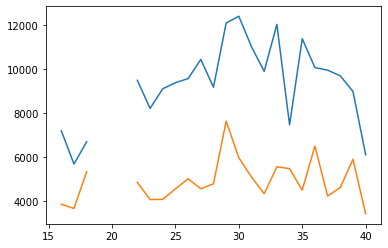

In [191]:
#7, 11, 12, 16
intvol[12].plot()
intgauss[12].plot()